# Intersecting faults

This tutorial builds upon the `3D_mesh_builder.ipynb` example using the `qdyn.compute_mesh_coords` functionality to render complex meshes. In this previous tutorial, we created a pair of faults that were offset from one another, but were striking in the same direction. Here, we will create a pair of vertically-dipping, intersecting faults. Please see `3D_mesh_builder.ipynb` for several important notes and limitations for rendering arbitrary fault meshes. An additional caveat that applies to this tutorial, is that the faults need to be burried (i.e., no free-surface effects).

In [1]:
%matplotlib widget

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from scipy.signal.windows import cosine

from qdyn import qdyn

In [6]:
# Instantiate the QDYN class object
p = qdyn()

# Predefine parameters
t_yr = 3600 * 24 * 365.0    # Seconds per year
L = 5e3                     # Length of fault along-strike
W = 8e3                     # Length of fault along-dip
resolution = 5              # Mesh resolution / process zone width

# Get the settings dict
set_dict = p.set_dict

""" Step 1: Define simulation/mesh parameters """
# Global simulation parameters
set_dict["MESHDIM"] = 2        # Simulation dimensionality (2D fault in 3D medium)
set_dict["FAULT_TYPE"] = 2     # Thrust fault
set_dict["TMAX"] = 1*t_yr      # Maximum simulation time [s]
set_dict["NTOUT_LOG"] = 10     # Save log output every N steps
set_dict["NTOUT_OT"] = 100     # Save time series output every N steps
set_dict["NTOUT_OX"] = 100     # Save snapshot output every N steps
set_dict["NXOUT_OX"] = 1       # Snapshot resolution along-strike (every N elements)
set_dict["NWOUT_OX"] = 1       # Snapshot resolution along-dip (every N elements)
set_dict["V_PL"] = 1e-9        # Plate velocity
set_dict["MU"] = 3e10          # Shear modulus
set_dict["SIGMA"] = 1e7        # Effective normal stress [Pa]
set_dict["ACC"] = 1e-7         # Solver accuracy
set_dict["SOLVER"] = 2         # Solver type (Runge-Kutta)
set_dict["Z_CORNER"] = -1e9    # Base of the fault (depth taken <0)
set_dict["DIP_W"] = 0          # Dip of the fault (note, this will become the "strike")
set_dict["NPROC"] = 8
set_dict["FEAT_STRESS_COUPL"] = 1

# Setting some (default) RSF parameter values
set_dict["SET_DICT_RSF"]["A"] = 0.2e-2    # Direct effect (will be overwritten later)
set_dict["SET_DICT_RSF"]["B"] = 1.0e-2    # Evolution effect
set_dict["SET_DICT_RSF"]["DC"] = 1e-3     # Characteristic slip distance
set_dict["SET_DICT_RSF"]["V_SS"] = set_dict["V_PL"]    # Reference velocity [m/s]
set_dict["SET_DICT_RSF"]["V_0"] = set_dict["V_PL"]     # Initial velocity [m/s]
set_dict["SET_DICT_RSF"]["TH_0"] = 0.99 * set_dict["SET_DICT_RSF"]["DC"] / set_dict["V_PL"]    # Initial (steady-)state [s]

# Process zone width [m]
Lb = set_dict["MU"] * set_dict["SET_DICT_RSF"]["DC"] / (set_dict["SET_DICT_RSF"]["B"] * set_dict["SIGMA"])
# Nucleation length [m]
Lc = set_dict["MU"] * set_dict["SET_DICT_RSF"]["DC"] / ((set_dict["SET_DICT_RSF"]["B"] - set_dict["SET_DICT_RSF"]["A"]) * set_dict["SIGMA"])

print(f"Process zone size: {Lb} m \t Nucleation length: {Lc} m")

# Find next power of two for number of mesh elements along-strike
Nx = int(np.power(2, np.ceil(np.log2(resolution * L / Lb))))
# Along-dip direction doesn't need to be a power of 2
Nw = int(resolution * W / Lb)

# Set mesh size and fault length
set_dict["NX"] = Nx
set_dict["NW"] = Nw
set_dict["L"] = L
set_dict["W"] = W
# Set time series output node to the middle of the fault
set_dict["IC"] = Nx * (Nw // 2) + Nx // 2

set_dict["VERBOSE"] = 0

""" Step 2: Set (default) parameter values and generate mesh """
p.settings(set_dict)
p.render_mesh()

Process zone size: 300.0 m 	 Nucleation length: 375.0 m


True

QDYN assumes that the fault mesh is Euclidean (uniform planar) along-strike. But there is a trick: if we ignore the free surface (which breaks the symmetry of a homogeneous elastic medium), we can arbitrarily rotate our reference frame and interchange the strike and dip directions. So two vertical strike-slip faults with different strike directions can be generated as two dipping faults with different dip directions. To prevent the free-surface from breaking the symmetry, we place the fault at an arbitrarily large depth below the surface, at which the free-surface has negligible effect.

In [7]:
split = Nw // 2     # Cut the mesh as this location
strike_angle = 45.  # Difference in strike angle between each fault

# Create a vector of dip values for the mesh
dip = np.ones(Nw) * set_dict["DIP_W"]
dip[:split] = strike_angle

# Create a vector of mesh element spacings
dw = np.ones(Nw) * (W / Nw)

# Override the default mesh with these new dip/spacing values
p.compute_mesh_coords(p.mesh_dict, dip, dw)

We can further override te re-computed mesh coordinates to shift the faults such that they intersect. Each fault is also populated with b-values that taper off to the edges of the fault.

In [8]:
# Get the mesh b-values
b = p.mesh_dict["B"].reshape((Nw, Nx))

# Define tapers to let the b-value go to zeroes at the edges of each fault
taper1 = np.outer(cosine(split), cosine(Nx))
taper2 = np.outer(cosine(Nw-split), cosine(Nx))

# Apply the tapers to each fault
b[:split] *= taper1
b[split:] *= taper2

# Override the default mesh values
p.mesh_dict["B"] = b.ravel()

# Get the mesh x-coordinate values
X = p.mesh_dict["X"].reshape((Nw, Nx))
Y = p.mesh_dict["Y"].reshape((Nw, Nx))
Z = p.mesh_dict["Z"].reshape((Nw, Nx))

# Apply a constant offset for each element on the first fault
Y[:split] += 2.0e3
Z[:split] += 0.5e3

# Override the mesh coordinates
p.mesh_dict["Y"] = Y.ravel()
p.mesh_dict["Z"] = Z.ravel()

# Assign fault labels (useful for postprocessing)
p.mesh_dict["FAULT_LABEL"][:split*Nx] = 1
p.mesh_dict["FAULT_LABEL"][split*Nx:] = 2

# Write input to qdyn.in
p.write_input()

True

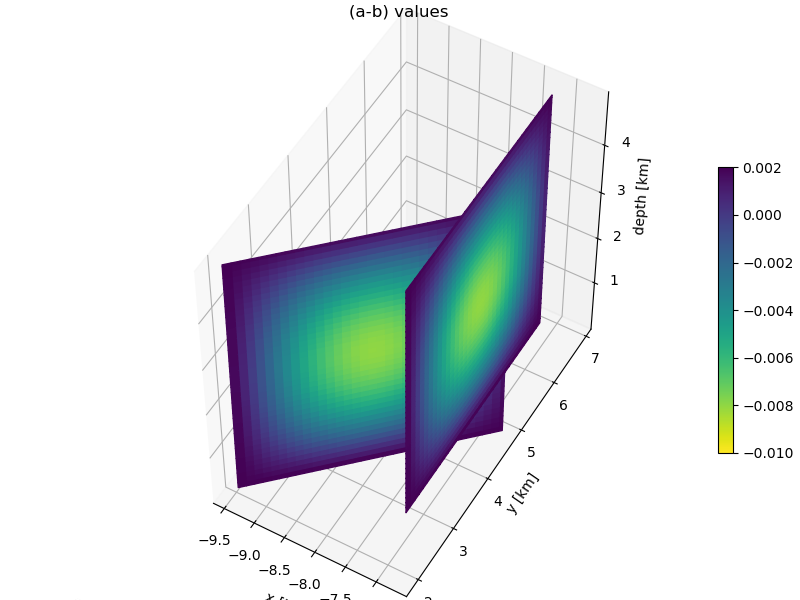

In [9]:
# Get the mesh values and reshape them into matrices
# Rotate the x and z directions to visualise our faults in the rotated reference frame
z = p.mesh_dict["X"].reshape((Nw, Nx)) * 1e-3
y = p.mesh_dict["Y"].reshape((Nw, Nx)) * 1e-3
x = p.mesh_dict["Z"].reshape((Nw, Nx)) * 1e-3
aminb = (p.mesh_dict["A"] - p.mesh_dict["B"]).reshape((Nw, Nx))

# Define colour scales for (a-b) and mesh spacing
norm = cm.colors.Normalize(vmin=-1e-2, vmax=2e-3)
cmap = cm.viridis_r

plt.close("all")
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True, subplot_kw={"projection": "3d"})

# Plot (a-b)
CS = ax.plot_surface(x[:split], y[:split], z[:split], facecolors=cmap(norm(aminb[:split])), antialiased=True, shade=False)
ax.plot_surface(x[split:], y[split:], z[split:], facecolors=cmap(norm(aminb[split:])), antialiased=True, shade=False)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink=0.5)
ax.set_title("(a-b) values")
ax.set_xlabel("x [km]")
ax.set_ylabel("y [km]")
ax.set_zlabel("depth [km]")
ax.set_aspect("equal")
ax.view_init(elev=51, azim=-60)

plt.show()

In [ ]:
p.run()

In [10]:
p.read_output(read_ot=True, read_ox=True)

/home/vanden/qdyn/qdyn/pyqdyn.py:796: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data_ox = read_csv(filename_ox, header=None, names=quants_ox, delim_whitespace=True, comment="#")


True

After reading the output, we can visualise the simulation results. The matplotlib 3D plotting capabilities are limited, but creating a 3D scatter plot does the job...

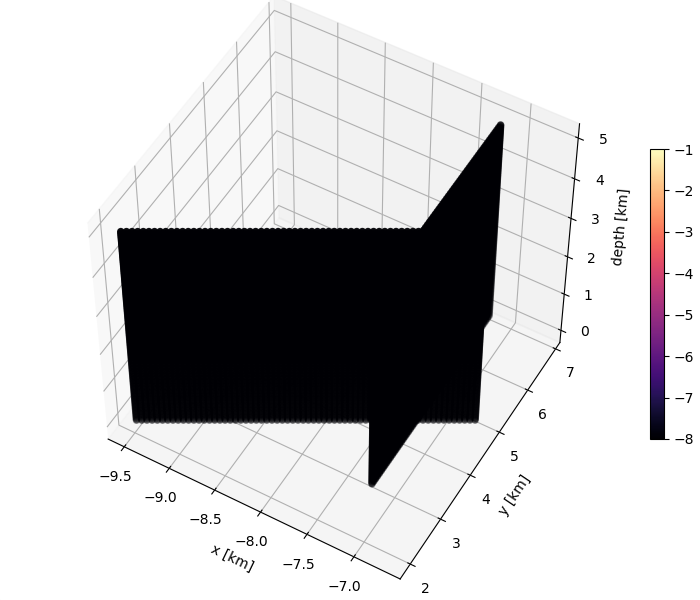

In [11]:
from matplotlib import animation

# Plotting parameters
surface_kwargs = {
    "linewidth": 0,
    "antialiased": False,
    "shade": False,
}


# Select a time interval
t_vals = np.sort(p.ox["t"].unique())

# Initial snapshot
t_vmax = p.ot[0]["t"].iloc[np.argmax(p.ot[0]["v"])]
inds = (p.ox["t"] == p.ox["t"].min())
# inds = (p.ox["t"] == t_vmax)

# Output was created every dN elements
dNw = set_dict["NWOUT_OX"]
dNx = set_dict["NXOUT_OX"]

Nx_out = int(np.ceil(Nx / dNx))
Nw_out = int(np.ceil(Nw / dNw))

# Select x/y/z and slip rate (v)
z2 = p.ox["x"][inds].values.reshape((Nw_out, Nx_out)) * 1e-3
y2 = p.ox["y"][inds].values.reshape((Nw_out, Nx_out)) * 1e-3
x2 = p.ox["z"][inds].values.reshape((Nw_out, Nx_out)) * 1e-3
v = np.log10(p.ox["v"][inds].values.reshape((Nw_out, Nx_out)))

# Colour scale normalisation
norm = cm.colors.Normalize(vmin=-8, vmax=-1)
cmap = cm.magma

# Location of our mesh split
split_out = Nw_out

# Frames per second of the animation
fps = 20

# Draw canvas
plt.close("all")
fig, ax = plt.subplots(figsize=(7, 6), constrained_layout=True, subplot_kw={"projection": "3d"})

# Decorate axes
ax.set_xlabel("x [km]")
ax.set_ylabel("y [km]")
ax.set_zlabel("depth [km]")

# Set initial viewing angle
ax.set_aspect("equal")
ax.view_init(elev=51, azim=-60)

# Plot first snapshot
CS = ax.scatter(x[:split_out].ravel(), y[:split_out].ravel(), z[:split_out].ravel(), c=cmap(norm(v[:split_out].ravel())))
CS2 = ax.scatter(x[split_out:].ravel(), y[split_out:].ravel(), z[split_out:].ravel(), c=cmap(norm(v[split_out:].ravel())))
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink=0.5)

# Collect figure elements
plots = [CS, CS2]

def update(n, plots):
    """ Routine to update figure elements """
    
    # Select time interval
    inds = p.ox["t"] == t_vals[n]
    # Select corresponding slip rate values
    v = np.log10(p.ox["v"][inds].values.reshape((Nw_out, Nx_out)))

    CS.set_facecolor(cmap(norm(v[:split_out].ravel())))
    CS2.set_facecolor(cmap(norm(v[split_out:].ravel())))

    return plots
    
# Render animation and save
ani = animation.FuncAnimation(fig, update, fargs=(plots,), interval=1000/fps, blit=True, frames=len(t_vals))
ani.save("animation.mp4")
plt.show()